In [1]:

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense,AveragePooling2D,BatchNormalization,Conv2D,Input,Flatten,Activation,concatenate,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [2]:

# Hyperparameters
batch_size = 64
num_classes = 10
num_filter = 12
compression = 0.5

In [3]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

170500096/170498071 [==============================] - 2s 0us/step


In [4]:

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=10/50, random_state=42)

In [5]:

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_cv = tf.keras.utils.to_categorical(y_cv, num_classes)

In [6]:

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape,y_cv.shape)

(40000, 32, 32, 3) (40000, 10)
(10000, 32, 32, 3) (10000, 10)
(10000, 32, 32, 3) (10000, 10)


In [7]:

class Convolution():
    '''
    Before entering the first dense vlock, a convolution with 16 (or twice the 
    growth rate for BC type) output channels is performed on the input images
    '''
    def __init__(self, growthRate = 12, weight_decay=1E-4):
        self.growthRate = growthRate
        self.weight_decay = weight_decay
        
    def __call__(self, x):
        
        #x = Activation('relu')(x)
        op = Conv2D(int(2*self.growthRate),3,padding="same",use_bias=False,bias_initializer='zeros',kernel_regularizer=l2(self.weight_decay))(x)
        
        return op

In [8]:

# test code
in_ = Input(shape=(32,32,3))
op = Convolution()(in_)
print(op.shape)

(None, 32, 32, 24)


In [9]:

class Bottelneck():
    """
    This class implements H(l) as mentioned in paper.
    BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3) version of H.
    """
    
    def __init__(self,growthrate = 12,weight_decay=1E-4):
        
        self.growthrate = growthrate
        self.weight_decay = weight_decay
        
        
    def __call__(self,x):
        """
        This is where logic lives.
        """
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(4*self.growthrate),1,padding="same",use_bias=False,kernel_initializer="he_uniform",kernel_regularizer=l2(self.weight_decay))(x)
        
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(self.growthrate),3,padding="same",use_bias=False,kernel_initializer="he_uniform",kernel_regularizer=l2(self.weight_decay))(x)
        
        return x

In [10]:

class Transition():
    """
    This class implements transition layer as per paper.
    BN-Con-pooling
    """  
    def __init__(self,compression = 0.5,growthrate = 12,weight_decay=1E-4):
        
        self.compression = compression
        self.growthrate = growthrate
        self.weight_decay = weight_decay
        
    def __call__(self,x):
        
        nChannels = x.shape.as_list()[-1]
        
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(self.compression * nChannels),1,padding="same",use_bias=False,kernel_regularizer=l2(self.weight_decay))(x)
        x = AveragePooling2D(pool_size=(2,2))(x)
        
        return x

In [11]:

class Densenet():
    """
    This layer implements densenet.
    """
    def __init__(self,depth,growthrate = 12,bottleneck = True):
        
        nDenseLayers = (depth-4) // 3
        if bottleneck:
            nDenseLayers //= 2
        
        self.nDenseLayers = nDenseLayers
        self.growthrate = growthrate
        
            
    def __call__(self,x):
        
        # Dense Block logic
        
        # convolution block
        x = Convolution()(x)
        
        # 1st dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])
            
        # transition layer
        x = Transition()(x)
            
        # 2nd dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])
            
        # transition layer
        x = Transition()(x)

        # 3rd dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])

        return x

In [12]:
class Output():
    """
    This layer implements output layer.
    """
    
    def __init__(self,num_classes = 10,weight_decay=1E-4):
        
        self.num_classes = num_classes
        self.weight_decay = weight_decay
        
    def __call__(self,x):
      
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = GlobalAveragePooling2D()(x)
        #avg = AveragePooling2D(pool_size=(8,8))(x)
        #flt = Flatten()(avg)
        op = Dense(self.num_classes,activation="softmax",kernel_regularizer=l2(self.weight_decay), bias_regularizer=l2(self.weight_decay))(x)
        
        return op

In [13]:
in_ = Input(shape=(32,32,3))

# densenet
op = Densenet(100)(in_)

# output 
op = Output()(op)

In [14]:

model = Model(inputs = in_,outputs = op)
sgd = tf.keras.optimizers.SGD(lr = 0.1,momentum = 0.9,nesterov = True)
model.compile(sgd,loss="categorical_crossentropy",metrics=["acc"])

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:

#callbacks
from time import time
from datetime import datetime


from tensorflow.python.keras.callbacks import TensorBoard

filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
history = tf.keras.callbacks.History()

# tensorboard
tensorboard = TensorBoard(log_dir="model_logs/{}".format(time()))

filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpoint_save = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_save,learning_rate_reduction,history,tensorboard]

In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.3,
    rotation_range=15,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='nearest')

cv_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_datagen.fit(X_train)
cv_datagen.fit(X_cv)
test_datagen.fit(X_test)

In [19]:
epochs = 100
batch_size = 64
val_batch_size = 64
steps = len(y_train)//batch_size
val_steps = len(y_cv)//val_batch_size

In [20]:

model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=64),steps_per_epoch=steps,
                    epochs=100,callbacks=callbacks_list,
                    validation_data=cv_datagen.flow(X_cv,y_cv,batch_size=64),validation_steps = val_steps)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 3.2277 - acc: 0.4225
Epoch 00001: val_acc improved from -inf to 0.49629, saving model to weights.01-2.93.hdf5
625/625 [==============================] - 87s 140ms/step - loss: 3.2277 - acc: 0.4225 - val_loss: 2.9305 - val_acc: 0.4963
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 2.4375 - acc: 0.6049
Epoch 00002: val_acc did not improve from 0.49629
625/625 [==============================] - 82s 131ms/step - loss: 2.4375 - acc: 0.6049 - val_loss: 3.7146 - val_acc: 0.3785
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 1.9806 - acc: 0.6879
Epoch 00003: val_acc improved from 0.49629 to 0.58173, saving model to weights.03-2.39.hdf5
625/625 [==============================] - 81s 130ms/step - loss: 1.9806 - acc: 0.6879 - val_loss: 2.3894 - val_acc: 0.5817
Epoch 4/100
625/625 [==============================] - ETA: 0s - loss: 1.6893 - acc: 0.7299
Epoch 00004: val_acc improved

Epoch 29/100
625/625 [==============================] - ETA: 0s - loss: 0.4109 - acc: 0.9406
Epoch 00029: val_acc did not improve from 0.91496
625/625 [==============================] - 78s 125ms/step - loss: 0.4109 - acc: 0.9406 - val_loss: 0.5191 - val_acc: 0.9104
Epoch 30/100
625/625 [==============================] - ETA: 0s - loss: 0.4047 - acc: 0.9431
Epoch 00030: val_acc improved from 0.91496 to 0.91727, saving model to weights.30-0.49.hdf5
625/625 [==============================] - 79s 126ms/step - loss: 0.4047 - acc: 0.9431 - val_loss: 0.4924 - val_acc: 0.9173
Epoch 31/100
625/625 [==============================] - ETA: 0s - loss: 0.3943 - acc: 0.9463
Epoch 00031: val_acc did not improve from 0.91727
625/625 [==============================] - 79s 127ms/step - loss: 0.3943 - acc: 0.9463 - val_loss: 0.5243 - val_acc: 0.9077
Epoch 32/100
625/625 [==============================] - ETA: 0s - loss: 0.3885 - acc: 0.9476
Epoch 00032: val_acc did not improve from 0.91727
625/625 [=====

625/625 [==============================] - ETA: 0s - loss: 0.2947 - acc: 0.9750
Epoch 00057: val_acc did not improve from 0.93009
625/625 [==============================] - 77s 123ms/step - loss: 0.2947 - acc: 0.9750 - val_loss: 0.4477 - val_acc: 0.9299
Epoch 58/100
625/625 [==============================] - ETA: 0s - loss: 0.2943 - acc: 0.9751
Epoch 00058: val_acc did not improve from 0.93009
625/625 [==============================] - 77s 123ms/step - loss: 0.2943 - acc: 0.9751 - val_loss: 0.4469 - val_acc: 0.9299
Epoch 59/100
625/625 [==============================] - ETA: 0s - loss: 0.2919 - acc: 0.9752
Epoch 00059: val_acc did not improve from 0.93009

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0001.
625/625 [==============================] - 77s 124ms/step - loss: 0.2919 - acc: 0.9752 - val_loss: 0.4486 - val_acc: 0.9296
Epoch 60/100
625/625 [==============================] - ETA: 0s - loss: 0.2931 - acc: 0.9743
Epoch 00060: val_acc did not improve from 0.93009
625

Epoch 88/100
625/625 [==============================] - ETA: 0s - loss: 0.2879 - acc: 0.9764
Epoch 00088: val_acc did not improve from 0.93009
625/625 [==============================] - 78s 124ms/step - loss: 0.2879 - acc: 0.9764 - val_loss: 0.4483 - val_acc: 0.9289
Epoch 89/100
625/625 [==============================] - ETA: 0s - loss: 0.2865 - acc: 0.9766
Epoch 00089: val_acc did not improve from 0.93009
625/625 [==============================] - 78s 124ms/step - loss: 0.2865 - acc: 0.9766 - val_loss: 0.4485 - val_acc: 0.9287
Epoch 90/100
625/625 [==============================] - ETA: 0s - loss: 0.2881 - acc: 0.9764
Epoch 00090: val_acc did not improve from 0.93009
625/625 [==============================] - 78s 125ms/step - loss: 0.2881 - acc: 0.9764 - val_loss: 0.4481 - val_acc: 0.9283
Epoch 91/100
625/625 [==============================] - ETA: 0s - loss: 0.2866 - acc: 0.9778
Epoch 00091: val_acc did not improve from 0.93009
625/625 [==============================] - 77s 123ms/ste

In [23]:
LOG_DIR = './model_logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

In [24]:
score = model.evaluate_generator(test_datagen.flow(X_test, y_test, batch_size=64), verbose=1)

157/157 [==============================] - 5s 33ms/step - loss: 0.4638 - acc: 0.9247


In [25]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4638172388076782
Test accuracy: 0.9247000217437744


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
import numpy as np
# Predict the values from the validation dataset
X_test = X_test.astype('float32')
X_test /= 255

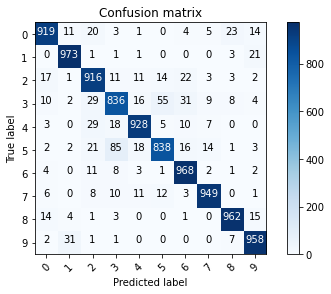

In [28]:
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))